# Step - 0

** Business Problem:** Urban wear is a clothing brand that's launching an eCommerce store. Currently, the pre launch page is collecting emails from site visitors. The plan is to collect as many emails for the product launch

As a product data scientist at urban wear, your job is to design, run and analyze an AB experiment that tests the two versions of the email sign up on the pre-launch page.

The control is the blue button which is the current version, the treatment is the green button.

Help the product team in deciding which version is better after analyzing the AB experiment

** Contact **

If you have any questions, please email engmazam786@gmail.com

In [56]:
## Importing libraries

from datetime import datetime
import random
import math

import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

# Disable warnings
from warnings import filterwarnings
filterwarnings('ignore')

#Set seed
SEED = 123
np.random.seed(SEED)

## load Data

In [57]:
# Set data path and load data
data_path = './Data/'
pretest = pd.read_csv(data_path + 'pretest.csv')
print('Pretest Data imported')

test = pd.read_csv(data_path + 'test.csv')
print('Test Data Imported')

# Converting the date column to date_field
pretest['date'] = pd.to_datetime(pretest['date'])
test['date'] = pd.to_datetime(test['date'])

Pretest Data imported
Test Data Imported


# Understanding the Business Problem

The first crucial step in AB testing is understanding the business problem. So, in this case is to look at the daily visitors count and the current sign up rate and help the stakeholders in visualising it with the help of some charts how the current scenerio looks like

In [80]:
# Display the first five rows of the pre test table
pretest.head()

,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0
3,4,2021-12-01,NaN,NaN,NaN,0
4,5,2021-12-01,NaN,NaN,NaN,0


In [82]:
test['experiment'].unique()

array([nan, 'email_test'], dtype=object)

In [59]:
# Show some stats about the pretest table

print('The number of rows in the pretest table are ', pretest.shape[0])
print(f"The date range of the data collected is {pretest['date'].min()} to  {pretest['date'].max()}")

The number of rows in the pretest table are  309903
The date range of the data collected is 2021-12-01 00:00:00 to  2021-12-31 00:00:00


In [60]:
# Let's check for the missingness. What is the null rate per column?
pretest.isnull().mean()

visitor_id    0.000000
date          0.000000
email         0.899017
experiment    0.903070
group         0.903070
submitted     0.000000
dtype: float64

In [61]:
## Initial stats about the pretest
print('The total visiot count :', pretest['visitor_id'].nunique())
print('The total sign up count :', pretest['submitted'].sum())
print('The sign up rate :', pretest['submitted'].mean().round(2))

The total visiot count : 309903
The total sign up count : 31295
The sign up rate : 0.1


## Plot visitors per day

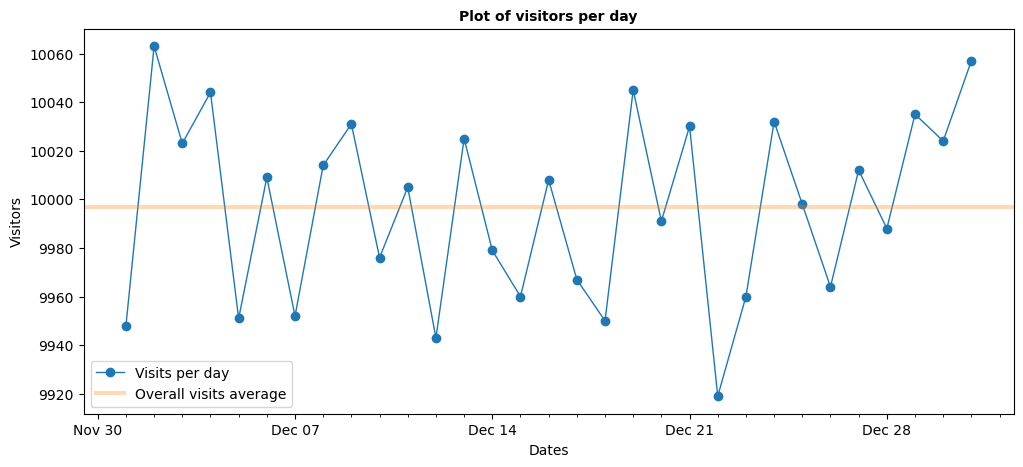

In [62]:
# Set the color palette for the plot
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

# Visitors per day and overall average
visits_per_day = pretest.groupby('date')['visitor_id'].count()
visits_mean = visits_per_day.mean()

#Plot Data
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(visits_per_day.index, visits_per_day, color=c1, linewidth=1, marker='o', label='Visits per day')
plt.axhline(visits_mean, color=c2, linewidth=3, alpha=0.3, label='Overall visits average')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())

plt.title('Plot of visitors per day', fontsize=10, fontweight='bold')
plt.xlabel('Dates', fontsize=10)
plt.ylabel('Visitors', fontsize=10)
plt.legend()
plt.show()

## Plot of sign up rate per day

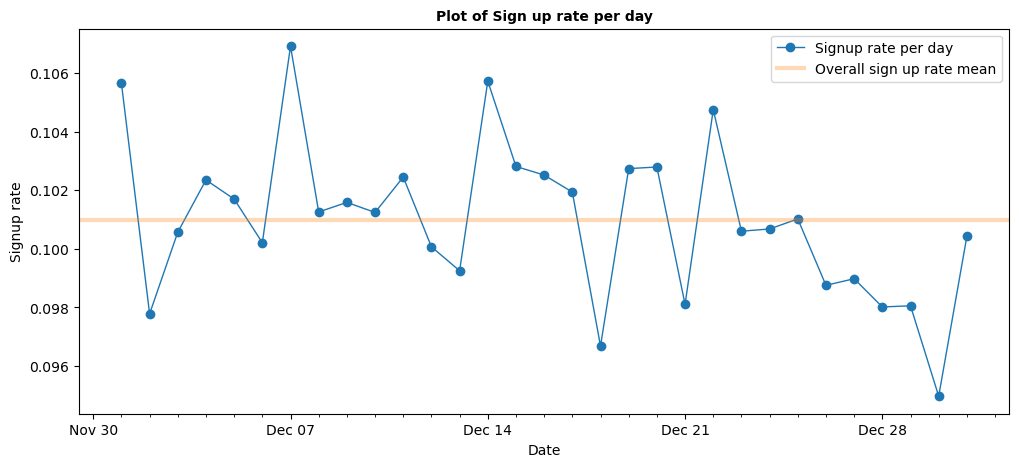

In [63]:
# sign up rate per day and it's mean
signup_rate_per_day = pretest.groupby('date')['submitted'].mean()
signup_rate_mean = signup_rate_per_day.mean()

#plot the graph
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(signup_rate_per_day.index, signup_rate_per_day, color=c1, marker='o', linewidth=1, label='Signup rate per day')
plt.axhline(signup_rate_mean, color=c2, linewidth=3, alpha=0.3, label='Overall sign up rate mean')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())

plt.title('Plot of Sign up rate per day', fontsize=10, fontweight='bold')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Signup rate', fontsize=10)
plt.legend()
plt.show()

# Step 1 - State the Hypothesis

The second step of the experiment is to state the hypothesis. This is followed by setting parameters like alpha, statistical power and minimum detectable effect

Ho - The sign rates of blue and green buttons are same

Ha- The sign up rates of blue and green buttons are different

In [64]:
# Setting some parameters
alpha = 0.05  # reject the null hypothesis, if the p value found is less than alpha
power = 0.80  # Ensure that there is an 80% percent chance of detecting an effect with statistical significance
mde = 0.10    # Detect a 10 percent increase in the signup rate with statistical significance

# Proportions if the effect exists
p1 = 0.10   # Control Green Button
p2 = p1 * (1+0.10)  #Treatment Blue Button

# Step 2 - Design the Experiment

The third step of the experiment is to design the experiment which involves determining the randomization unit, calculating the sample size and determining the experiment duration. We will explore how to calculate the sample size and experiment duration.

#### Calculate sample size

To detect an effect of 10.0% from an initial sign rate of 10%, The sample size required per group is 15000
The total sample required in the experiment is 30000


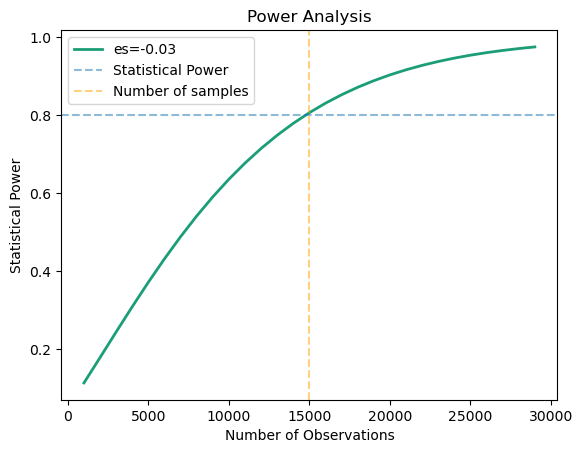

In [72]:
# Calculate the effect size using cohen'd for proportions
cohen_d = sm.stats.proportion_effectsize(p1, p2)

# To calculate the sample size n for the given cohen_d, power and alpha
n = tt_ind_solve_power(effect_size=cohen_d, alpha=alpha, power=power)
n = int(round(n, -3)) # Round up to nearest thousands

print(f'To detect an effect of {100*(p2/p1-1):.1f}% from an initial sign rate of {100*p1:.0f}%, '
      f'The sample size required per group is {n}'
      f'\nThe total sample required in the experiment is {2*n}')

# Explore power across all sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs',nobs=np.arange(1000, 30000, 1000), effect_size=[cohen_d], title='Power Analysis')

plt.axhline(0.8, linestyle='--', label='Statistical Power', alpha=0.5)
plt.axvline(15000, linestyle='--', color='orange', alpha=0.5, label='Number of samples')
plt.legend()
plt.ylabel('Statistical Power')
plt.show()

#### Experiment duration

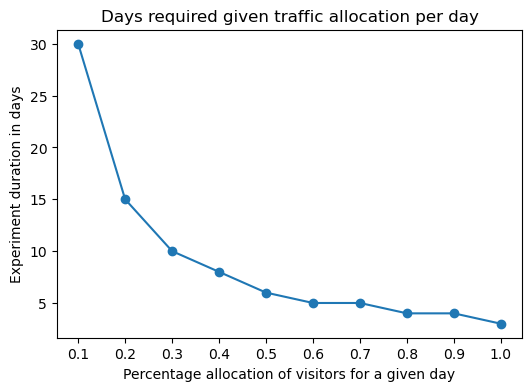

In [76]:
# What is the duration required to achieve the required sample size 
# given the percentage of unique visitors allocated to the experiment?

alloc = np.arange(0.10, 1.1, 0.10)
size = round(visits_mean, -3) * alloc
days = np.ceil(2 * n/ size)

# Plot the graph
f, ax = plt.subplots(figsize=(6,4))
ax.plot(alloc, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days required given traffic allocation per day')
plt.ylabel('Experiment duration in days')
ax.set_xlabel('Percentage allocation of visitors for a given day')
plt.show()

In [77]:
print(f'To run an experiment for 21 days , {np.ceil(2*n/21)} users are required per day')  # Too long
print(f'To run an experiment for 14 days , {np.ceil(2*n/14)} users are required per day')  # Sweet spot between risk and time
print(f'To run an experiment for 07 days , {np.ceil(2*n/7)} users are required per day')   # Too risky

To run an experiment for 21 days , 1429.0 users are required per day
To run an experiment for 14 days , 2143.0 users are required per day
To run an experiment for 07 days , 4286.0 users are required per day


# Step 4 - Run the experiment

We will look at the step analysing the AB experiment. The code below shows a simplified version about how data is collected and analyzed in a large scale experiment platform

In [140]:
# Get the subset tables of control and treatment group
AB_test = test[test['experiment'] == 'email_test']
control_signups = AB_test[AB_test['group']==0]['submitted']
treatment_signups = AB_test[AB_test['group']==1]['submitted']

control_signups_total = control_signups.sum()
treatment_signups_total = treatment_signups.sum()
control_signup_rate = control_signups.mean()
treatment_signup_rate = treatment_signups.mean()
control_signups_count = control_signups.count()
treatment_signups_count = treatment_signups.count()

print(f'Control signup rate : {control_signup_rate:.4}')
print(f'Treatment signup rate :{treatment_signup_rate:.4}')

Control signup rate : 0.09557
Treatment signup rate :0.1078


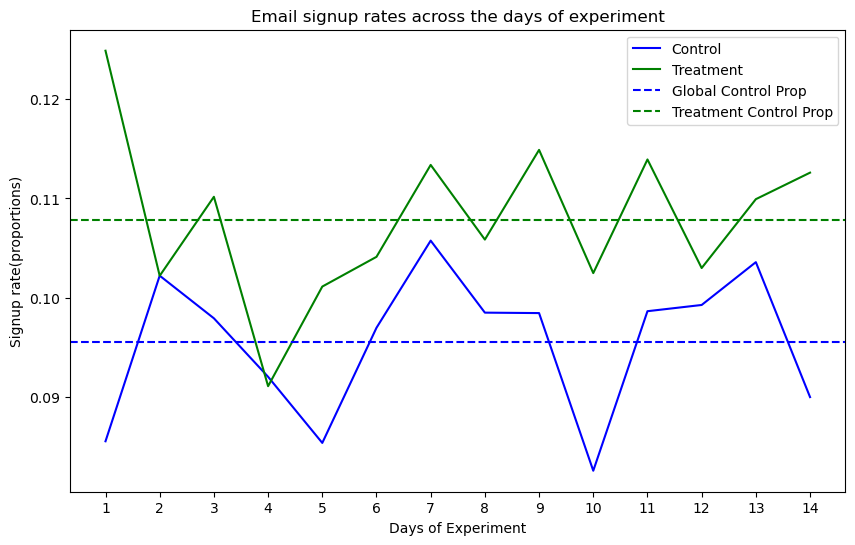

In [141]:
# Plot signups per day for each group
signups_per_day = AB_test.groupby(['group', 'date'])['submitted'].mean()
control_props = signups_per_day.loc[0]
trt_props = signups_per_day.loc[1]

# Get the days of experiment
days = range(1, AB_test['date'].nunique() + 1)

# Let's plot the sign rates of both control and treatment group with days
f, ax = plt.subplots(figsize=(10,6))

ax.plot(days, control_props, label='Control', color='b')
ax.plot(days, trt_props, label='Treatment', color='g')
ax.axhline(control_signup_rate, color='b', linestyle='--', label='Global Control Prop')
ax.axhline(treatment_signup_rate, color='g', linestyle='--', label='Treatment Control Prop')
plt.xticks(days)
plt.title('Email signup rates across the days of experiment')
plt.ylabel('Signup rate(proportions)')
plt.xlabel('Days of Experiment')
plt.legend()
plt.show()

# Assessing Validity threats

In this experiment, we run two statistical tests to check for the validity of AB test. We first run AA test to check the experimental environment and then run chi square test of sample mismatch ratio(SRM)

We run an AA test to ensure that there is no underlying difference between the control and treatment to begin with. 

We run the chi square test of sizes to determine that there is no fault in randomization algorithm

## AA test

In [142]:
# Let's get some stats about AA test first

AA_test = pretest[pretest['experiment'] == 'AA_test']

AA_control = AA_test[AA_test['group'] == 0]['submitted']
AA_treatment = AA_test[AA_test['group'] == 1]['submitted']

AA_control_size = AA_control.count()
AA_treatment_size = AA_treatment.count()
AA_control_count = AA_control.sum()
AA_treatment_count = AA_treatment.sum()
AA_control_signuprate = AA_control.mean()
AA_treatment_signuprate = AA_treatment.mean()

print(f'AA control signup rate : {AA_control_signuprate:.4f}')
print(f'AA treatment signup rate : {AA_treatment_signuprate:.4f}')

AA control signup rate : 0.1015
AA treatment signup rate : 0.0988


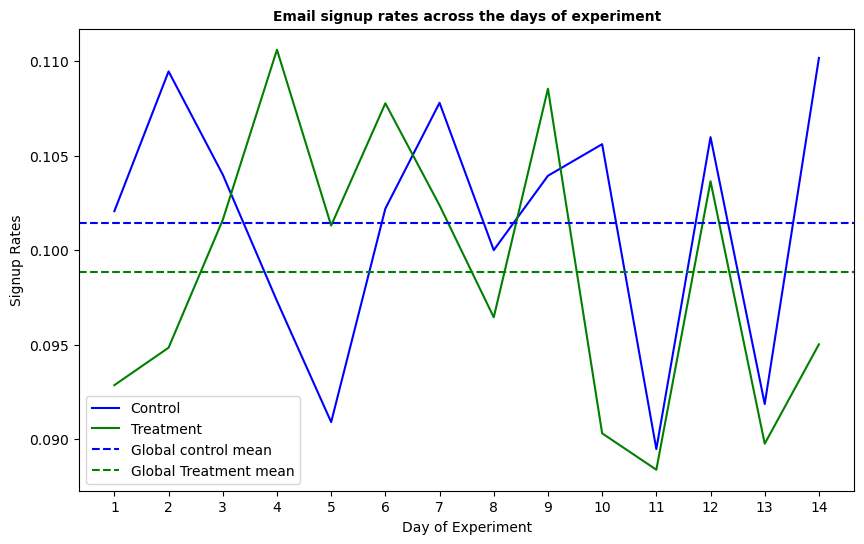

In [143]:
# Plot the sign up rate with date also
AA_signups_per_day = AA_test.groupby(['group', 'date'])['submitted'].mean()
AA_control_props = AA_signups_per_day.loc[0]
AA_treatment_props = AA_signups_per_day.loc[1]

# Get the days from the date
days = range(1, AA_test['date'].nunique()+1)

# Plot the graph
f, ax = plt.subplots(figsize=(10,6))
ax.plot(days, AA_control_props, color='b', label='Control')
ax.plot(days, AA_treatment_props, color='g', label='Treatment')
ax.axhline(AA_control_signuprate, linestyle='--', color='b', label='Global control mean')
ax.axhline(AA_treatment_signuprate, linestyle='--', color='g', label='Global Treatment mean')

plt.title('Email signup rates across the days of experiment', fontsize=10, fontweight='bold')
plt.ylabel('Signup Rates')
ax.set_xlabel('Day of Experiment')
plt.xticks(days)
ax.legend()
plt.show()

In [144]:
# Run a chi square test to see wether the difference is significant

AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_count, AA_treatment_count], nobs=[AA_control_size, AA_treatment_size])

# Grab dates
min_date = AA_test['date'].min().date()
max_date = AA_test['date'].max().date()

# Set the alpha for AA test
AA_alpha = 0.05

print(f'_______AA Test ({min_date} - {max_date})_______\n')
print('Ho - The sign up rates between blue and green are the same.')
print('Ha - The sign up rates between blue and green are different.\n')
print(f'Significance level : {AA_alpha}')
print(f'Chi-square - {AA_chistats}, p-value - {AA_pvalue}')

print('\nConclusions:')
if AA_pvalue < AA_alpha:
    print('Reject Ho and conclude that both control and treatment groups are different, Check for instrumentation errors')
else:
    print('Fail to reject Ho and therefore proceed with AB test')

_______AA Test (2021-12-18 - 2021-12-31)_______

Ho - The sign up rates between blue and green are the same.
Ha - The sign up rates between blue and green are different.

Significance level : 0.05
Chi-square - 0.5767232986599099, p-value - 0.44759955698947684

Conclusions:
Fail to reject Ho and therefore proceed with AB test


## Sample Ratio Mismatch

In [145]:
# Lets check for the sample ratio mismatch

# Set test parameter
SRM_ALPHA = 0.05

email_test = test[test['experiment'] == 'email_test']
observed = email_test.groupby('group')['experiment'].count().values
print(observed)
expected = [email_test.shape[0] * 0.5] * 2
print(expected)
# Perform chi square goodness of fit test
chi_stats, p_value = stats.chisquare(f_obs=observed, f_exp=expected)

print('-' * 10 + 'Test for Sample Ratio Mismatch' + '-' * 10 + '\n')
print('Ho : The ratio of samples is 1:1')
print('Ha : The ratio of samples is not 1:1')

print(f'\nSignificance Level : {SRM_ALPHA}')
print(f' Chi square value : {chi_stats:.3f}, p-value : {p_value:.3f}\n')
print('Conclusion:')
if p_value < SRM_ALPHA:
    print('Reject Ho and conclude that there is smaple ratio mismatch and the sample ratio is not 1:1')
else:
    print('Fail to reject Ho. Therefore, there is no SRM')

[14942 15139]
[15040.5, 15040.5]
----------Test for Sample Ratio Mismatch----------

Ho : The ratio of samples is 1:1
Ha : The ratio of samples is not 1:1

Significance Level : 0.05
 Chi square value : 1.290, p-value : 0.256

Conclusion:
Fail to reject Ho. Therefore, there is no SRM


# Conduct Statitical Inference

In [146]:
# set the alpha for ab test
ALPHA_AB = 0.05

## Chi Squared Test

In [147]:
# Conduct the chi squared test for proportions to whether the sign up rates in AB test are different

AB_chistat, p_value, _ = proportions_chisquare([control_signups_total, treatment_signups_total], nobs=[control_signups_count, treatment_signups_count])

# Grad dates
min_date = AB_test['date'].min().date()
max_date = AB_test['date'].max().date()

print(f'-----------AB test email Sign Ups {min_date} to {max_date} ---------\n')
print('Ho : The sign up rates between the blue and green buttons are the same')
print('Ha : The sign up rates between the blue and green buttons are different')
print('\nSignificance level : ', ALPHA_AB)
print(f'Chi-square : {AB_chistat:.3f}, p_value : {p_value:.5f}')

if p_value < ALPHA_AB:
    print('Reject Ho and conclude that there is statistical significance between the sign up rates of Blue and Green Button')
else:
    print('Fail to reject Ho')


-----------AB test email Sign Ups 2022-02-01 to 2022-02-14 ---------

Ho : The sign up rates between the blue and green buttons are the same
Ha : The sign up rates between the blue and green buttons are different

Significance level :  0.05
Chi-square : 12.312, p_value : 0.00045
Reject Ho and conclude that there is statistical significance between the sign up rates of Blue and Green Button


## T Test for Proportions

In [152]:
# Let's run t-test for proportions

# Execute test
AB_tstat, AB_pvalue, _ = ttest_ind(treatment_signups, control_signups)

# Grab dates from the data
min_date = AB_test['date'].min().date()
max_date = AB_test['date'].max().date()

print(f'----------- AB test from {min_date} to {max_date} --------\n')
print('Ho : The sign up rates of both green and blue button are same')
print('Ha : The sign up rates of green and blue buttons are different')
print(f'\nStastical Significance : {ALPHA_AB}')
print(f'T-stat value : {AB_tstat:.3f}, p_value : {AB_pvalue:.5f}\n')

if AB_pvalue < ALPHA_AB:
    print('Reject Ho and conclude that there is statistical significance between the sign up rates of Blue and Green Button')
else:
    print('Fail to reject Ho')

----------- AB test from 2022-02-01 to 2022-02-14 --------

Ho : The sign up rates of both green and blue button are same
Ha : The sign up rates of green and blue buttons are different

Stastical Significance : 0.05
T-stat value : 3.509, p_value : 0.00045

Reject Ho and conclude that there is statistical significance between the sign up rates of Blue and Green Button


## Final result with Confidence Interval

In [154]:
# Compute the confidence interval of the test
ci = confint_proportions_2indep(treatment_signups_total, treatment_signups_count, control_signups_total, control_signups_count,
                                compare='diff', alpha=0.05,correction=True)
lower = ci[0]
upper = ci[1]

lower_lift = ci[0] / control_signup_rate
upper_lift = ci[1]/ control_signup_rate

In [163]:
# print results

print('------- Sample Sizes------')
print(f'Control : {control_signups_count}')
print(f'Treatment : {treatment_signups_count}')

print('\n---------Sign up Counts(Rates)---------')
print(f'Control : {control_signups_total} ({control_signup_rate * 100:.1f})%')
print(f'Treatment : {treatment_signups_total} ({treatment_signup_rate * 100:.1f})%')

print('\n---------Differences--------')
print(f'Absolute : {treatment_signup_rate - control_signup_rate:.4f}')
print(f'Relative(lift) : {(treatment_signup_rate - control_signup_rate) * 100 / control_signup_rate:.1f}%')

print('\n--------T stats-------')
print(f'Test Statistic : {AB_tstat:.3f}')
print(f'p-value : {AB_pvalue:.5f}')

print('\n-----------Confidence Intervals----------')
print(f'Absolute Difference CI : ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI : ({lower_lift * 100:.1f}%, {upper_lift * 100:.1f}%)')

------- Sample Sizes------
Control : 14942
Treatment : 15139

---------Sign up Counts(Rates)---------
Control : 1428 (9.6)%
Treatment : 1632 (10.8)%

---------Differences--------
Absolute : 0.0122
Relative(lift) : 12.8%

--------T stats-------
Test Statistic : 3.509
p-value : 0.00045

-----------Confidence Intervals----------
Absolute Difference CI : (0.005, 0.019)
Relative Difference (lift) CI : (5.7%, 19.9%)


# Step 7 - Decide Whether to Launch

In the email sign-up test for the Urban Wear pre-launch page, we aimed to improve the sign-up rate by changing the submit button color from blue to green.

We ran a two-week randomized controlled experiment (02/01/2022 - 02/14/2022) that enrolled a sample of users into the control (blue) and treatment (green) groups.

From the test, we observed an improvement of 12.8% lift from the benchmark (blue) at 9.6%. The result was statistically significant with a 95% confidence interval between 5.7% and 19.9%. 

Given that we observed practical and statistical significance, our recommendation is to launch the new submit button in green.